# Flower Image Classifier with [PyTorch](https://pypi.org/project/torch/0.1.2/) <a class="tocSkip">

### Application of neural networks for image classification—using tools in [`torchvision`](https://pytorch.org/docs/0.3.0/torchvision/index.html) <a class="tocSkip">

---
## Motivation and overview

The objective of this project is to build an application that can be trained on any set of labeled images, using the tool in [PyTorch](https://pypi.org/project/torch/0.1.2/)

The PyTorch documentation describes it as a Python package that provides two high-level features:
- Tensor computation (like NumPy) with strong GPU acceleration 
- Deep Neural Networks built on a tape-based autograd system

The network instance in this Jupyter notebook will be trained on flower images—[102 Category Flower Dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html)—and will provide predictions via a command line application. Below is an example of the type of images included in this dataset:

<img src='example_image/Flowers.png' width=300px>

The project in this notebook is broken down into three main steps:

1. Load and preprocess the image dataset
2. Train the image classifier on your dataset
3. Use the trained classifier to predict image content


---
## Import Python modules

In [ ]:
# Import Python libraries  
import json
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from PIL import Image

# Import PyTorch libraries
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

# Pretty display for Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Print Python version for future reference
print(sys.version)

---
## Load the data

This application will be trained on flower images—[102 Category Flower Dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html). 

The data—which will be loaded using the tools in [`torchvision`](http://pytorch.org/docs/0.3.0/torchvision/index.html)—is split into three directories: training, validation, and testing ([download here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz)). 

For the training images, I apply transformations such as random scaling, cropping, and flipping. This enhances the training data, which will help the network when it encounters new images, hopefully producing better out-of-sample performance. The input flower images come in many sizes, so they must be resized to **224 by 224** pixels as required by the pre-trained networks.

The pre-trained networks I use here were trained on the [ImageNet dataset](http://image-net.org/about-overview), where each color channel was normalized separately. Therefore I also scale all images so the means and standard deviations match what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]` (calculated from the ImageNet images).

Below I rely on the `torchvision` package (which consists of popular datasets, model architectures, and common image transformations for computer vision) to build the three datasets: training, validation, and testing.

**Steps:**

1. Define image transformations, some of which are necessary so that the input images match the expected arguments for the pre-trained network. Additionally, random transforms are recommended to enhance the training data and the performance of the model. `torchvision.transforms` is used to define image transforms and to chain them together using `transforms.Compose`.

2. Build datasets based on the data directories and pipeline of transforms. Use `torchvision.datasets.ImageFolder`. 

3. Define `dataloaders` which will be used to loop through the datasets. `torch.utils.data.DataLoader` combines a dataset and a sampler, and provides iterators over the dataset.

In [3]:
# Stats needed to normalize ImageNet images
means = [0.485, 0.456, 0.406]
std_devs = [0.229, 0.224, 0.225]
input_size = 224

# Other transforms parameters 
down_size = 256
rotation = 30

# Determine batch size for DataLoaders
_batch_size = 64

In [4]:
# Define transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(rotation),
                                 transforms.RandomResizedCrop(input_size),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(means, std_devs)]),
    'valid': transforms.Compose([transforms.Resize(down_size),
                                        transforms.CenterCrop(input_size),
                                        transforms.ToTensor(),
                                        transforms.Normalize(means, std_devs)]),
    'test': transforms.Compose([transforms.Resize(down_size),
                                        transforms.CenterCrop(input_size),
                                        transforms.ToTensor(),
                                        transforms.Normalize(means, std_devs)])
    }

# Build datasets and apply transforms (with ImageFolder)
image_datasets = {
    'train': datasets.ImageFolder('flowers/train/', 
                                  transform=data_transforms['train']),
    'valid': datasets.ImageFolder('flowers/valid/', 
                                  transform=data_transforms['valid']),
    'test': datasets.ImageFolder('flowers/test/', 
                                 transform=data_transforms['test'])
    }

# Define dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], 
                                         batch_size=_batch_size, shuffle=True),
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], 
                                         batch_size=_batch_size),
    'test': torch.utils.data.DataLoader(image_datasets['test'], 
                                        batch_size=_batch_size)
    }

### Load label mapping

Each one of the three datasets contains a numbered directory of images per each flower category. So we need a mapping from numbered label to flower category name. For instance, `"51": "petunia"`. This mapping is in the file `cat_to_name.json`.

In [5]:
# Open JSON file and store in dictionary 
with open('cat_to_name.json', 'r') as f:
    label_to_name = json.load(f)

---
## Build the classifier

This section consists of two major steps:

1. Start by downloading one of the pre-trained network architectures in PyTorch `torch.utils.model_zoo`; that is, by calling a given constructor in [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) and passing `pretrained=True`.

2. Build a new, untrained feed-forward network as a classifier, with ReLU activations and dropout. Use `torch.nn.Sequential`.

### Load pre-trained network:  VGG-11

In [6]:
# Download and instantiate pre-trained network: VGG-11
model = models.vgg11(pretrained=True)

In [7]:
# Display VGG-11 network architecture
display(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

### Build new classifier layers

The classifier layers of the pre-trained network must be replaced with a classifier that fits the parameters of our flower-image classification problem.

Before building and replacing the network classifier, I will exclude all pre-trained parameters from gradient computation.

In [8]:
# Freeze updating of pre-trained parameters
for param in model.parameters():
    param.requires_grad = False

The input in the new classifier must match the output of the pre-trained network (25,088). The output of the classifier will be the set of image categories in the flowers datasets (102).

In [9]:
# Parameters 
in_features = 25088
out_categories = 102
layer_1 = 512

# Build classifier
classifier = nn.Sequential(OrderedDict([
    ('dropout1', nn.Dropout(0.5)),
    ('fc1', nn.Linear(in_features, layer_1)),
    ('relu', nn.ReLU()),
    ('dropout2', nn.Dropout(0.5)),
    ('fc2', nn.Linear(layer_1, out_categories)),
    ('output', nn.LogSoftmax(dim=1))
    ]))

# Assign new classifier to VGG-11 architecture 
model.classifier = classifier

---
## Train the classifier and track running performance

The two main tasks in this section are the following:

1. Train the classifier layers using *backpropagation* and the pre-trained network to get the features.

2. Track the loss and accuracy on the validation set to determine the best hyper-parameters.

### Train the classifier layers

I start by instantiating the necessary classes for the optimization component of network training.

First, the loss function will be a *Negative Log Likelihood* (`torch.nn.NLLLoss`)

Second, the optimization method will be the *Adam algorithm* (`torch.optim.Adam`).

In [11]:
# Instantiate loss function
loss_function = nn.NLLLoss()

# Instantiate optimization algorithm 
learning_rate = 0.0001
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

# Enable CUDA: use GPUs for model computation
if torch.cuda.is_available():
    model.to('cuda')

Define parameters for the training loop. 

In [90]:
# Epochs: number of iterations over the entire training dataset
epochs = 6
# Number of iterations between printing loss and accuracy 
print_steps = 30

In [51]:
%%time

# Initialize steps
step = 0

# Iterate over number of epochs
for e in range(epochs):
    running_loss = 0 

    # Iterate over the entire training dataset
    # one batch per iteration 
    for input_images, labels in dataloaders['train']:
        step += 1     
        
        # Enable CUDA: use GPUs for model computation
        if torch.cuda.is_available():
            inputs, labels = inputs.to('cuda'), labels.to('cuda')   
        
        # Clear the gradients of all optimized tensors
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model.forward(input_images)
        loss = loss_function(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate and print running training loss
        running_loss += loss.item()       
        if step % print_steps == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_steps))
            running_loss = 0
        
print('\nCount of data batches seen:  {} \n'.format(step))

Epoch: 1/1...  Loss: 1.0716
Epoch: 1/1...  Loss: 1.0607
Epoch: 1/1...  Loss: 1.0139

Count of data batches seen:  103 

CPU times: user 1h 4min 32s, sys: 8min 39s, total: 1h 13min 12s
Wall time: 18min 21s


>**Running loss over training cycles:**

    Epoch: 1/6...  Loss: 2.5249
    Epoch: 1/6...  Loss: 2.2719
    Epoch: 1/6...  Loss: 2.1266
    Epoch: 2/6...  Loss: 1.0807
    Epoch: 2/6...  Loss: 1.6770
    Epoch: 2/6...  Loss: 1.6962
    Epoch: 3/6...  Loss: 0.2008
    Epoch: 3/6...  Loss: 1.5353
    Epoch: 3/6...  Loss: 1.4367
    Epoch: 3/6...  Loss: 1.3798    
    Epoch: 4/6...  Loss: 1.2882
    Epoch: 4/6...  Loss: 1.2619
    Epoch: 4/6...  Loss: 1.2889
    Epoch: 5/6...  Loss: 1.1873
    Epoch: 5/6...  Loss: 1.1387
    Epoch: 5/6...  Loss: 1.1314
    Epoch: 6/6...  Loss: 1.0716
    Epoch: 6/6...  Loss: 1.0607
    Epoch: 6/6...  Loss: 1.0139

    Count of data batches seen:  618 

### Calculate accuracy on the validation set 

In the cells below I use the trained network to make predictions on the validation dataset. 

The goal is to tune the hyper-parameters of the model in order to achieve validation accuracy of at least 80%.

In [52]:
# Initialize validation counters
validation_correct = 0
validation_total = 0

# no_grad() prevents tracking history (and using memory)
with torch.no_grad(): 
    
    # Iterate over the entire validation dataset
    for input_images, labels in dataloaders['valid']:
        
        # Enable CUDA: use GPUs for model computation
        if torch.cuda.is_available():
            input_images, labels = input_images.to('cuda'), labels.to('cuda')
        
        # Make predictions 
        outputs = model(input_images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Count total and correct predictions
        validation_total += labels.size(0)
        validation_correct += (predicted == labels).sum().item()

In [53]:
# Print validation accuracy
print('Validation accuracy ({0:d} validation images): {1:.1%}'
      .format(validation_total, validation_correct / validation_total))

Validation accuracy (818 validation images): 82.9%


---
## Test the performance of the network

In order to obtain an appropriate estimate for model performance on completely new images we rely on the test dataset: images the network has never seen either in training or validation.

Below I run the test images through the network and measure the accuracy; as done above for the validation set.

In [77]:
# Initialize test counters
test_correct = 0
test_total = 0

# no_grad() prevents tracking history (and using memory)
with torch.no_grad(): 
    
    # Iterate over the entire validation dataset
    for input_images, labels in dataloaders['test']:
        
        # Enable CUDA: use GPUs for model computation
        if torch.cuda.is_available():
            input_images, labels = input_images.to('cuda'), labels.to('cuda')
        
        # Make predictions 
        outputs = model(input_images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Count total and correct predictions
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

In [78]:
print('Testing accuracy ({0:d} test images): {1:.1%}'
      .format(test_total, test_correct / test_total))

Testing accuracy (819 test images): 91.0%


---
## Save the trained network

Now that the network is trained, I save the model so it can be loaded later to make predictions. 

In order to save the model allowing for the option to keep training it later, I also save the necessary training parameters: number of epochs and the optimizer state.

In [81]:
# Save the mapping of the flower labels (1-102) to array indices (0-101)
model.class_to_idx = image_datasets['train'].class_to_idx

In [97]:
# Create dictionary with needed components to rebuild model
checkpoint = {
    'model': model,
    'epochs': epochs,
    'optimizer_state': optimizer.state_dict,
    'labels_to_flower_names': label_to_name
    }

# Save checkpoint
torch.save(checkpoint, 'checkpoint_05-15-2019.pth')

## Use the trained model for inference:  flower classification 

In this section I put the model to use, taking the necessary steps to process new flower images and to make classification inferences or predictions.

### Pre-process input images

In the inference or prediction steps below, I will use `PIL` (Python Imaging Library) to load new flower images. But the output that results of loading a new `PIL.Image` object cannot be passed directly to the trained network. 

The function below, `process_image()`, processes a `PIL` image so that it is ready to be converted into a PyTorch tensor and passed to the trained classifier. The function includes the following main tasks:

1. Resize image so that the shortest side is 256 pixels, keeping the aspect ratio.

2. Crop out the center 224x224 portion of the image.

3. Re-encode image color channels so they match model input requirements, from integers 0-255 to floats 0-1.

4. Normalize image accordingly to the same statistics used to train the network (on ImageNet images). Means: `[0.485, 0.456, 0.406]`. Standard deviations: `[0.229, 0.224, 0.225]`.

5. Reorder the dimensions of the normalized image — NumPy array — so that it matches PyTorch's expected input (i.e., the color channel is expected to be the first dimension, not the third dimension as in a PIL image). 

In [54]:
# Stats needed to normalize ImageNet images
ImageNet = {
    'means' : np.array([0.485, 0.456, 0.406]),
    'std_devs' : np.array([0.229, 0.224, 0.225]),
    'short_ax_max' : 255,
    'resize' : 224
    }

In [106]:
# Process a PIL image for use in a PyTorch model
def process_image(pil_image, image_reqs=ImageNet):
    """Scale, crop, and normalize a PIL image for a PyTorch model.
    Returns a NumPy array
    
    Args:
       pil_image (PIL image): Input image for a prediction task 
       image_reqs (dict): Image stats needed so image matches model reqs
    Returns:
        NumPy array
    
    """
    # Resize image so that shortest side is 256 pixels, keeping ratio
    img_size = pil_image.size
    ratio = max(img_size) / min(img_size)
    new_size = [0, 0]
    short = img_size.index(min(img_size))
    long = 1 - short 
    new_size[short] = image_reqs['short_ax_max']
    new_size[long] = int(image_reqs['short_ax_max'] * ratio)
    pil_image = pil_image.resize(size=tuple(new_size))
    
    # Crop out the center 224x224 portion of the image
    gap_x = int((new_size[0] - image_reqs['resize']) / 2)
    gap_y = int((new_size[1] - image_reqs['resize']) / 2)
    crop_box = (gap_x, gap_y, gap_x + image_reqs['resize'], 
                gap_y + image_reqs['resize']) 
    pil_image = pil_image.crop(box=crop_box)
    
    # Re-encode image color channels
    np_image = np.array(pil_image) / 255
    
    # Normalize image accordingly to the same statistics used to train 
    norm_image = (np_image - image_reqs['means']) / image_reqs['std_devs']
    
    # Reorder dimensions of NumPy array so it matches PyTorch's input
    norm_image = norm_image.transpose((2, 0, 1))
    
    return norm_image

### Deploy trained network for predictions

Now that images are processed to the expected PyTorh format, they can be passed into a function that uses the trained model to make predictions. 

A common practice is to predict the top 5, or so, most probable classes (usually called top-$K$). The function below, `predict()`, takes the image filepath and the trained model — and returns the ordered lists of the most likely classes and their corresponding probabilities.

In [112]:
# Load a flower image and make a prediction of the top-K classes
def predict(img_filepath, model, topk=5):
    ''' Predict the top-K classes of an image using a trained 
    deep learning model.
    
    Args:
       img_filepath (str): Input image for the prediction task 
       model (torchvision.models): Trained deep learning model
       topk (int): Number of top most likely predictions
    Returns:
        top_probs (list)
        classes (list)
    
    '''
    # Open PIL image
    pil_image = Image.open(img_filepath)
    # Scale, crop, normalize PIL image
    np_image = process_image(pil_image, image_reqs=ImageNet) 
    
    # Resize NumPy array to match dataloader output
    np_image = np.resize(np_image,(1, 3, 224, 224))
    # Covert NumPy array to PyTorch tensor
    img_tensor = torch.from_numpy(np_image).type(torch.FloatTensor)

    # Enable CUDA: use GPUs for model computation
    if torch.cuda.is_available():
        img_tensor = img_tensor.to('cuda')
    
    # Run model in evaluation mode 
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
    
    # Convert softmax output to probabilities
    probs = torch.exp(outputs.data)
    
    # Find top-k probabilities and indices 
    top_probs, indices = torch.topk(probs, dim=1, k=topk)
    
    # Convert PyTorch tensors to lists
    top_probs, indices = top_probs.to('cpu').numpy(), indices.to('cpu').numpy()
    top_probs, indices = top_probs[0].tolist(), indices[0].tolist()
    
    # Find the class using the indices (reverse dictionary first)
    idx_to_class = {idx: class_ for class_, idx in model.class_to_idx.items()}
    classes = [idx_to_class[i] for i in indices]

    return top_probs, classes    

### Sanity check:  Make a flower category prediction  

In this final section we will check whether the predictions that come out of the image classification tool make sense. 

This will not be a comprehensive test, but just a *sanity check* to screen for obvious bugs and errors. 

The main steps in this prediction test are the following:

1. Choose a flower image, of known category, from the test set. And run the image through the trained network using the `predict()` function.

2. Get the flower names (in words) from the checkpoint dictionary, for the chosen test flower and the predicted top-$K$ classes.

3. Write the function `imshow()`, which takes the output of the `process_image()` function and re-processes the array to be plotted with `matplotlib`. This will let us visualize the input image as *seen* by the trained model. 

4. Display the test flower image along with a bar chart of the top-5 predicted categories.

#### Choose test image and run through the model

In [143]:
# Choose a flower category and individual image for prediction example
test_class = '74'
pathname = 'flowers/test/74/image_01307.jpg'

# Run predict() to get model predictions: top-k classes and probabilities 
probs, classes = predict(pathname, model, topk=5)

#### Get flower names from checkpoint dictionary

In [144]:
# Get the flower-category names from the saved checkpoint
flower_names = checkpoint['labels_to_flower_names']
test_flower_name = flower_names[test_class]
top_k_names = [flower_names[key] for key in classes] 

#### Write function to display test image as seen by model

In [145]:
def imshow(image, ax=None, title=None, image_reqs=ImageNet):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = image_reqs['means']
    std = image_reqs['std_devs']
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)

#### Display test image and chart of top-K classes

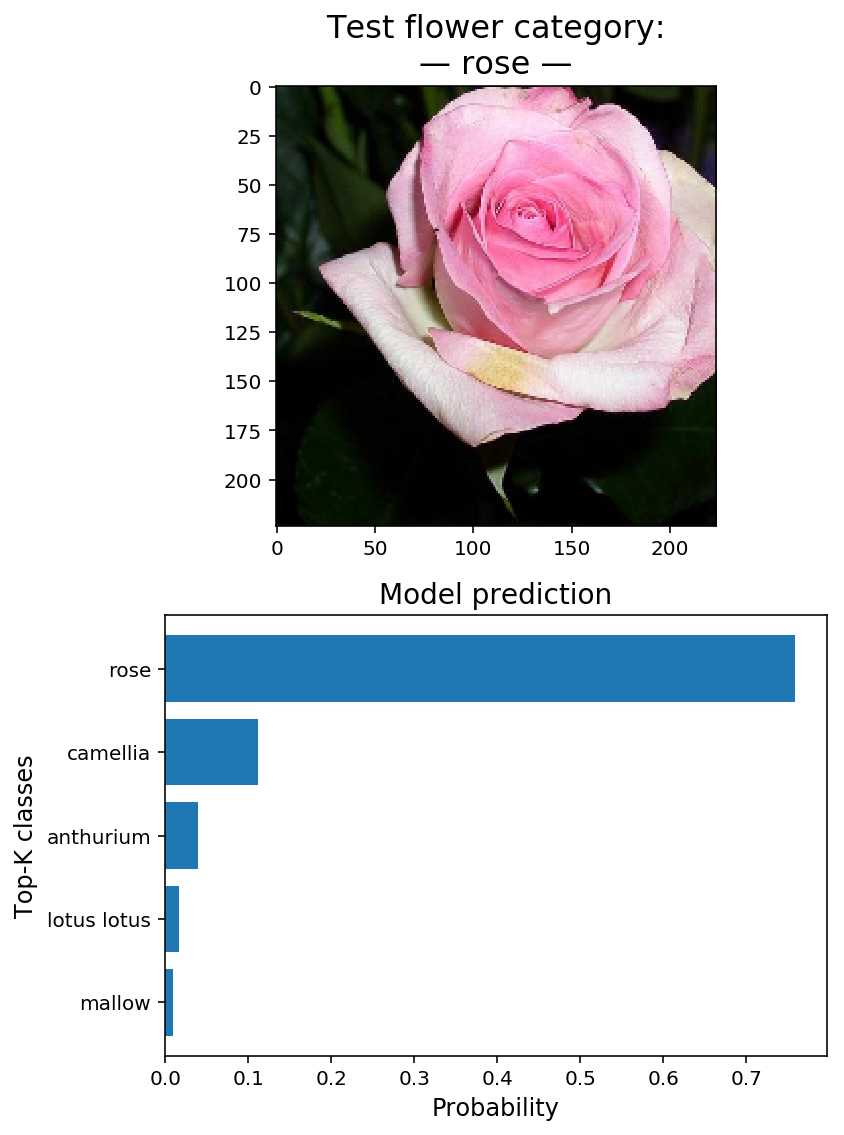

In [149]:
# Create figure and axes 
fig, (flower, prob_bars) = plt.subplots(nrows=2, ncols=1, figsize=(6,8))

# Render the flower image
imshow(image=process_image(Image.open(pathname)), ax=flower)

flower.set_title('Test flower category:\n— {} —'.format(test_flower_name), 
                 fontsize=16)

# Make barchart of top-k probabilities 
index = np.arange(len(classes))[::-1]
prob_bars.barh(index, probs, tick_label=top_k_names, align='center')
prob_bars.set_title('Model prediction', fontsize=14)
prob_bars.set_xlabel('Probability', fontsize=12)
prob_bars.set_ylabel('Top-K classes', fontsize=12)

# Plot the final figure
fig.tight_layout()

The image above shows that for this specific flower category and test image, the model is making a clear and correct prediction: **rose**.

Based on this limited test, we can conclude that there are no obvious errors or bugs in the tool at this point. 